In [6]:
from get_models import Progress_Bar, Encoder, Decoder, CovarianceMatrix, thermometer_encode_df

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import scipy.stats as stats
from scipy.stats import chi2

%load_ext autoreload
%autoreload 2

In [7]:
#Load dataframes: test_scores has high dimensional test score data of hfsme tests
test_scores_df = pd.read_csv(os.getcwd()+'/test_scores.csv')

#test_scores_df_encoded is a thermometer encoding of test_scores_df for the encoder network
test_scores_df_encoded = thermometer_encode_df(test_scores_df, test_scores_df.columns[1:])

#time_df contains data that changes with time, e.g.: age or time since medication switch
time_df = pd.read_csv(os.getcwd()+'/time_df.csv')
time_df['intercept'] = np.ones(time_df.shape[0])

#baseline_df contains features that characterizes patients at baseline
baseline_df = pd.read_csv(os.getcwd()+'/baseline_df.csv')

# 'sex' has no influence:
baseline_df['sex'] = np.random.randint(2, size=baseline_df.shape[0])

df_effects = pd.merge(baseline_df, time_df, on='patient_id', how='inner')

fixed_effects_keys = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never', 'sex']
random_effects_keys = ['intercept', 'since_medication', 'since_switch']

p = len(fixed_effects_keys)
q = len(random_effects_keys)

#vae latent dimension
latent_dim = 2

def get_ind(id, df):
    return np.where(df['patient_id'] == id)[0]

def get_design_matrix(df_effects, fixed_effects_keys, random_effects_keys, r=1, include_interaction=False):
    patient_id = df_effects['patient_id'].unique()

    X_list = [torch.from_numpy(np.array(df_effects.loc[get_ind(id, df_effects), fixed_effects_keys])).to(torch.float32) for id in patient_id]

    if include_interaction==True:
        for key in random_effects_keys[1:]:
            X_list = [torch.cat((X_i, X_i[:,1:] * torch.from_numpy(np.array(df_effects.loc[get_ind(patient_id[j], df_effects), key])).unsqueeze(-1)
                                ), -1).to(torch.float32) for j,X_i in enumerate(X_list)]

    X_list = [torch.cat((torch.from_numpy(np.array(df_effects.loc[get_ind(patient_id[j], df_effects), 'age'])).unsqueeze(-1), X_i), -1).to(torch.float32) for j,X_i in enumerate(X_list)]


    Z_list = [torch.from_numpy(np.array(df_effects.loc[get_ind(id, df_effects), random_effects_keys])).to(torch.float32) for id in patient_id]
    Z_list = [torch.block_diag(*[i for j in range(r)]) for i in Z_list]   
    X_list = [torch.block_diag(*[i for j in range(r)]) for i in X_list]
    return X_list, Z_list

#get the design matrices
X_list, Z_list = get_design_matrix(df_effects, fixed_effects_keys, random_effects_keys, r=latent_dim, include_interaction=False)

pat_ind = np.cumsum([0]+[int(len(X_i)/latent_dim) for X_i in X_list])

In [3]:
# initialize Encoder and Decoder Models and the Mixed Model Parameters. mode='diagonal': Diagonal Covariance Matrix, mode='full': Full Covariance Matrix,
def initialize(latent_dim, mode='diagonal'):
    encoder = Encoder(
        input_dim=np.shape(test_scores_df_encoded)[-1],
        hidden_dims=[150], 
        output_dim=latent_dim, 
        act=torch.nn.Tanh())

    decoder = Decoder(
        item_positions=np.concatenate([[i]*a for i,a in enumerate(np.array(test_scores_df[test_scores_df.columns[1:]].max(0)).astype(np.int32))]),                            
        input_dim=latent_dim,
        hidden_dims=[150], 
        act=torch.nn.Tanh())

    var_param = CovarianceMatrix(q*latent_dim, mode=mode)    
    return encoder, decoder, var_param

In [11]:
patients = torch.from_numpy(np.array(baseline_df['patient_id']))
num_patients = len(patients)

#Train the VAE model:  Weighting of the loss function
# alpha: kl-divergence weight;  
# delta: MSE distance between encoder prediction and decoder; 
# gamma: decoder reconstruction loss
# eta: mixed model loss

# batch_size should be greater than 50
def train_vae(epochs, batch_size, X_list, Z_list, encoder, decoder, var_param, optimizer_vae, alpha=1, gamma=1, delta=1, eta=1):
    steps = int(num_patients / batch_size)
    rng = np.random.default_rng(1234)
    prior = Normal(torch.zeros(torch.Size([latent_dim])), torch.ones(torch.Size([latent_dim])))
    progBar = Progress_Bar(epochs, steps, ['nELBO', 'KL', 'nML', 'Rec Loss', 'Residuals', 'Item Error'])

    
    for epoch in range(epochs):
        shuffle = rng.permutation(num_patients)
        
        for step in range(steps):
            #draw minibatch
            pat_batch = patients[shuffle[step*batch_size:(step+1)*batch_size]]
            pat_ind_batch = [torch.arange(pat_ind[i],pat_ind[i+1]) for i in pat_batch]
            
            ind_batch = []
            add = 0
            for ind in range(len(pat_ind_batch)):
                len_i = len(pat_ind_batch[ind])
                ind_batch += [torch.arange(add, add + len_i)]
                add += len_i

            Z_list_batch = [Z_list[pat] for pat in pat_batch]
            X_list_batch = [X_list[pat] for pat in pat_batch]
            
            # warum nicht torch.cat statt concatenate
            test_data = torch.concatenate([torch.from_numpy(np.array(test_scores_df_encoded.loc[ind])).to(torch.float32) for ind in pat_ind_batch])
            test_data_orig = torch.concatenate([torch.from_numpy(np.array(test_scores_df[test_scores_df.columns[1:]].loc[ind])).to(torch.int32) for ind in pat_ind_batch])
            
            optimizer_vae.zero_grad(set_to_none=True)
            #encode test scores
            mu, log_sig = encoder.encode(test_data)

            #reparametrization trick to get latent variables
            eps = prior.sample(torch.Size([log_sig.size(dim=0)]))
            z = mu + log_sig.exp() * eps
            
            #kl divergence
            kl = torch.mean(0.5 * torch.sum(mu.square() + torch.exp(2.0 * log_sig) - 1.0 - (2.0 * log_sig), dim=1))

            # get the response variable list (latent z)
            z_list = [z[ind].flatten().to(torch.float32) for ind in ind_batch]

            #Mixed model loglikelihood loss. Notation follows https://www.sfu.ca/sasdoc/sashtml/stat/chap41/sect23.htm
            Phi, sigma = var_param()
            N = sum([len(Z_i) for Z_i in Z_list_batch])

            V_list = [Z_i @ Phi @ Z_i.t() + torch.eye(Z_i.size(0)) * sigma for Z_i in Z_list_batch]
            V_inv_list = [V_i.inverse() for V_i in V_list]
            
            Xt_V_inv_X = torch.stack([X_i.t() @ V_i_inv @ X_i for X_i, V_i_inv in zip(X_list_batch, V_inv_list)]).sum(dim=0)
            Xt_V_inv_y = torch.stack([X_i.t() @ V_i_inv @ y_i for X_i, V_i_inv, y_i in zip(X_list_batch, V_inv_list, z_list)]).sum(dim=0)
#
            #Check if Xt_V_inv_X is invertible. Only needed for mini batching
            if torch.abs(torch.det(Xt_V_inv_X)) > 1e-6:
                EBLUE = Xt_V_inv_X.inverse() @ Xt_V_inv_y
                EBLUP_list = [Phi @ Z_i.t() @ V_i_inv @ (y_i - X_i @ EBLUE) for X_i, Z_i, V_i_inv, y_i in zip(X_list_batch, Z_list_batch, V_inv_list, z_list)]

                residual_list = [y_i - X_i @ EBLUE for y_i, X_i in zip(z_list, X_list_batch)]
                #Mixed model prediction
                z_pred = torch.cat([X_i @ EBLUE + Z_i @ EBLUP_i for X_i, Z_i, EBLUP_i in zip(X_list_batch, Z_list_batch, EBLUP_list)]).reshape((-1, latent_dim))

                log_det_V = torch.stack([V_i.det().clamp(min=1e-12).log() for V_i in V_list]).sum()
                const = torch.log(torch.tensor(2.0 * torch.pi))
                rt_V_inv_r = torch.stack([r_i.t() @ V_i_inv @ r_i for r_i, V_i_inv in zip(residual_list, V_inv_list)]).sum()

                #negative mixed models likelihood
                nML = 0.5 * (log_det_V + rt_V_inv_r + N * const) / N
                
                #distance between encoder latent variables and mixed model prediction
                residuals = ((z_pred - z) ** 2).sum(1).mean()

                #reconstruction loss
                rec_loss, probs = decoder(z, test_data_orig)
                nelbo = alpha * kl + delta * residuals  * 0 + gamma * rec_loss + eta * nML * 0
                
                nelbo.backward()
                optimizer_vae.step()

                data_pred = torch.stack([torch.argmax(pred, dim=-1) for pred in probs]) 
                # total test item prediction error  
                item_error = np.mean(np.sum(np.abs(data_pred.detach().numpy() - test_data_orig.T.numpy()), axis=0))

                progBar.update({
                    'nELBO': nelbo.item(), 
                    'KL': alpha * kl.item(), 
                    'nML': eta * nML.item(),
                    'Rec Loss': gamma * rec_loss.item(), 
                    'Residuals': delta * residuals.item(),
                    'Item Error': item_error,
                    }) 
            

encoder, decoder, var_param = initialize(latent_dim, mode='diagonal')
optimizer_vae = torch.optim.Adam([
    {'params': var_param.parameters(), 'lr': 0.1},  
    {'params': encoder.parameters(), 'lr': 0.01},  
    {'params': decoder.parameters(), 'lr': 0.01},  
])  

train_vae(300, 60,X_list, Z_list, encoder, decoder, var_param, optimizer_vae, alpha=1, gamma=1, delta=1, eta=1)  
torch.save({
        'epoch': 0,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'var_param': var_param,
        'optimizer_vae_state_dict': optimizer_vae.state_dict(),
        'X_list' : X_list,
        'Z_list' : Z_list,
    }, fr'C:\Users\yanni\OneDrive\Desktop\BachelorArbeit2024\Code\trained_models\vae_wo_mm.pth')
# get the model prediction:
def eval_vae(X_list, Z_list, var_param, encoder):
    with torch.no_grad():
        pat_ind_batch = [torch.arange(pat_ind[i],pat_ind[i+1]) for i in patients]
        prior = Normal(torch.zeros(torch.Size([latent_dim])), torch.ones(torch.Size([latent_dim])))

        test_data = torch.concatenate([torch.from_numpy(np.array(test_scores_df_encoded.loc[ind])).to(torch.float32) for ind in pat_ind_batch])

        mu, log_sig = encoder.encode(test_data)

        eps = prior.sample(torch.Size([log_sig.size(dim=0)])) 
        z = mu + log_sig.exp() * eps

        z_list = [z[ind].flatten().to(torch.float32) for ind in pat_ind_batch]

        Phi, sigma = var_param()
        N = sum([len(Z_i) for Z_i in Z_list])

        V_list = [Z_i @ Phi @ Z_i.t() + torch.eye(Z_i.size(0)) * sigma for Z_i in Z_list]
        V_inv_list = [V_i.inverse() for V_i in V_list]
        
        Xt_V_inv_X = torch.stack([X_i.t() @ V_i_inv @ X_i for X_i, V_i_inv in zip(X_list, V_inv_list)]).sum(dim=0)
        Xt_V_inv_y = torch.stack([X_i.t() @ V_i_inv @ y_i for X_i, V_i_inv, y_i in zip(X_list, V_inv_list, z_list)]).sum(dim=0)

        EBLUE = Xt_V_inv_X.inverse() @ Xt_V_inv_y
        EBLUP_list = [Phi @ Z_i.t() @ V_i_inv @ (y_i - X_i @ EBLUE) for X_i, Z_i, V_i_inv, y_i in zip(X_list, Z_list, V_inv_list, z_list)]

        residual_list = [y_i - X_i @ EBLUE for y_i, X_i in zip(z_list, X_list)]
        z_pred = torch.cat([X_i @ EBLUE + Z_i @ EBLUP_i for X_i, Z_i, EBLUP_i in zip(X_list, Z_list, EBLUP_list)]).reshape((-1, latent_dim))

        log_det_V = torch.stack([V_i.det().clamp(min=1e-12).log() for V_i in V_list]).sum()
        const = torch.log(torch.tensor(2.0 * torch.pi))
        rt_V_inv_r = torch.stack([r_i.t() @ V_i_inv @ r_i for r_i, V_i_inv in zip(residual_list, V_inv_list)]).sum()

        nML = 0.5 * (log_det_V + rt_V_inv_r + N * const) 
        return mu, z, z_pred, nML
    
mu, z, z_pred, nML = eval_vae(X_list, Z_list, var_param, encoder)

Progress: 76.7% - ETA: 0:03:25 - Epoch: 230 - Iteration: 920 - ms/Iteration: 732.2 - nELBO: 6.5505 (+0.280) - KL: 3.4628 (+0.141) - nML: 11134464165 (+0.041) - Rec Loss: 3.0877 (+0.139) - Residuals: 11467764532 (+0.103) - Item Error: 1.5738 (+0.052).           m).           

NameError: name 'i' is not defined

In [12]:
torch.save({
        'epoch': 0,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'var_param': var_param,
        'optimizer_vae_state_dict': optimizer_vae.state_dict(),
        'X_list' : X_list,
        'Z_list' : Z_list,
    }, fr'C:\Users\yanni\OneDrive\Desktop\BachelorArbeit2024\Code\trained_models\vae_wo_mm.pth')

In [9]:
def likelihood_ratio(L_full, L_red):
    return 2 * (L_full - L_red)

In [6]:
# RUN SIMULATION FOR n = num_simulations
num_simulations = 10
lrt_results= [] # List to save the results

all_epochs_dict = {} #dictionary to save all models in only one file

fixed_effects_keys_full = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never', 'sex']
random_effects_keys_full = ['intercept', 'since_medication', 'since_switch']
# reduced model without fixed effect 'sex' 
fixed_effects_keys_red = ['family_affected', 'sco_surg', '≤3', 'onset_age', 'presym_diag', 'presymptomatic', 'stand_lost', 'stand_gained', 'stand_never']
random_effects_keys_red = ['intercept', 'since_medication', 'since_switch']

# get design matrix for the full model
X_list_full, Z_list_full = get_design_matrix(df_effects, fixed_effects_keys_full, random_effects_keys_full, r=latent_dim)
# get design matrix for the reduced model
X_list_red, Z_list_red = get_design_matrix(df_effects, fixed_effects_keys_red, random_effects_keys_red, r=latent_dim)

for i in range(num_simulations):
    # reinitialize the parameters and the optimizer
    encoder_full, decoder_full, var_param_full = initialize(latent_dim) 
    optimizer_vae_full = torch.optim.Adam([
        {'params': var_param_full.parameters(), 'lr': 0.1},  
        {'params': encoder_full.parameters(), 'lr': 0.01},  
        {'params': decoder_full.parameters(), 'lr': 0.01},  
    ])
    train_vae(200, 60, X_list_full, Z_list_full, encoder_full, decoder_full, var_param_full, optimizer_vae_full)
    nML_full = eval_vae(X_list_full, Z_list_full, var_param_full, encoder_full)[3] # get the nML value 

    encoder_red, decoder_red, var_param_red = initialize(latent_dim) 
    optimizer_vae_red  = torch.optim.Adam([
        {'params': var_param_red.parameters(), 'lr': 0.1},  
        {'params': encoder_red.parameters(), 'lr': 0.01},  
        {'params': decoder_red.parameters(), 'lr': 0.01},  
    ])

    train_vae(200, 60, X_list_red, Z_list_red, encoder_red, decoder_red, var_param_red, optimizer_vae_red)
    nML_red = eval_vae(X_list_red, Z_list_red, var_param_red, encoder_red)[3]
    
    lrt_results.append(likelihood_ratio(nML_full, nML_red))
    
    # save the parameters of the trained model in a seperate datei
    # torch.save({
    #     'epoch': i,
    #     'encoder_full_state_dict': encoder_full.state_dict(),
    #     'decoder_full_state_dict': decoder_full.state_dict(),
    #     'var_param_full': var_param_full,
    #     'optimizer_vae_full_state_dict': optimizer_vae_full.state_dict(),
    #     'encoder_red_state_dict': encoder_red.state_dict(),
    #     'decoder_red_state_dict': decoder_red.state_dict(),
    #     'var_param_red': var_param_red,
    #     'optimizer_vae_red_state_dict': optimizer_vae_red.state_dict(),
    #     'X_list_full' : X_list_full,
    #     'Z_list_full' : Z_list_full,
    #     'X_list_red' : X_list_red,
    #     'Z_list_red' : Z_list_red
    # }, fr'C:\Users\yanni\OneDrive\Desktop\BachelorArbeit2024\Code\trained_models\models_epoch_{i}.pth')
    # save the trained models in the dictionary
    all_epochs_dict[f'epoch_{i}'] = {
        'encoder_full_state_dict': encoder_full.state_dict(),
        'decoder_full_state_dict': decoder_full.state_dict(),
        'var_param_full': var_param_full,
        'optimizer_vae_full_state_dict': optimizer_vae_full.state_dict(),
        'encoder_red_state_dict': encoder_red.state_dict(),
        'decoder_red_state_dict': decoder_red.state_dict(),
        'var_param_red': var_param_red,
        'optimizer_vae_red_state_dict': optimizer_vae_red.state_dict(),
        'X_list_full' : X_list_full,
        'Z_list_full' : Z_list_full,
        'X_list_red' : X_list_red,
        'Z_list_red' : Z_list_red
    }
    print(i)

# save the dict with all models in a seperate file
#torch.save(all_epochs_dict, r'C:\Users\yanni\OneDrive\Desktop\BachelorArbeit2024\Code\trained_models\complete_models_100_epochs.pth')

Progress: 78.4% - ETA: 0:01:48 - Epoch: 157 - Iteration: 627 - ms/Iteration: 627.1 - nELBO: 6.6083 (+0.321) - KL: 3.4218 (+0.046) - nML: 504427604 (-0.000) - Rec Loss: 3.1865 (+0.275) - Residuals: 70554676 (-0.007) - Item Error: 1.6159 (+0.126).                                    

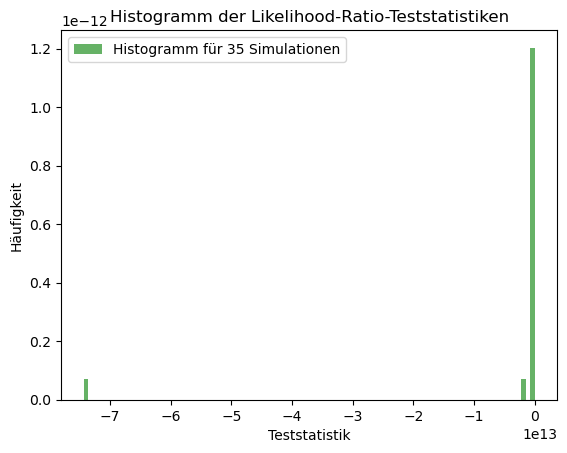

In [ ]:
# plot the histogr<am of the LRT-statistic
plt.hist(lrt_results, bins=100, density=True, alpha=0.6, color='g', label='Histogramm für 35 Simulationen')

#x = np.linspace(-8000, 8000, 100)
#plt.plot(x, chi2.pdf(x + 500, df=1), 'r-', lw=2, label='Chi-Quadrat-Verteilung (df=1)')

# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Histogramm anzeigen
plt.show()